In [175]:
!pip install dtaidistance

## Importar Librerias

In [176]:
# Conectar al entorno de Collab las carpetas de Google Drive
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
    SCALERS_DIR = '/content/drive/MyDrive/Colab Notebooks/SCALERS/'
    ENCODERS_DIR = '/content/drive/MyDrive/Colab Notebooks/ENCODERS/'
    OUTPUTS_DIR = '/content/drive/MyDrive/Colab Notebooks/OUTPUTS/'
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR
    SCALERS_DIR = '../../SCALERS/'
    ENCODERS_DIR = '../../ENCODERS/'
    OUTPUTS_DIR = '../../OUTPUTS/'

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [177]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from dtaidistance import dtw
import pandas as pd
from scripts import *
from sklearn.linear_model import LinearRegression
import random

In [178]:
# Verificar que el paquete dtaidistance está correctamente installado
dtw.try_import_c(verbose=True)

All ok ...
== Packages ==
- Numpy version: 2.0.2
- Matplotlib version: 3.10.0
- Scipy version: 1.15.3
== System information ==
namespace(name='cpython', cache_tag='cpython-311', version=sys.version_info(major=3, minor=11, micro=13, releaselevel='final', serial=0), hexversion=51056112, _multiarch='x86_64-linux-gnu')
== Compilation information ==
Compiler type: unix
--noopenmp: 0
--forceopenmp: 0
--noxpreprocessor: 0
--forcellvm: 0
--forcegnugcc: 0
--forcestatic: 0
Cython found (during compilation)
- Version: 3.0.12
- Locations: <module 'Cython' from '/tmp/pip-build-env-ww5_4di_/overlay/lib/python3.11/site-packages/Cython/__init__.py'>
Numpy found (during compilation):
- Version: 2.2.3
- Location: <module 'numpy' from '/tmp/pip-build-env-ww5_4di_/overlay/lib/python3.11/site-packages/numpy/__init__.py'>
Checking if gcc redirects to clang
gcc --version # with stdout=-1, stderr=-1, input=, encoding=ascii

Using GNU GCC settings (gcc)
Checking for OpenMP availability for gcc
gcc -dM -E -Xpre

True

In [179]:
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
sns.set_context("notebook", rc={"figure.figsize": (12, 6)})

In [180]:
path_products = DATOS_DIR+'tb_productos.txt'
path_stocks = DATOS_DIR+'tb_stocks.txt'
path_sells = DATOS_DIR+'sell-in.txt'
path_products_to_predict = DATOS_DIR+'product_id_apredecir201912.txt'

In [181]:
tn_scaler_path=SCALERS_DIR+'scalers.pkl'
encoders_path=ENCODERS_DIR+'encoders.pkl'

## Cargar Dataset

In [182]:
df_products = pd.read_csv(path_products, sep='\t', dtype={ 'product_id': str, 'sku_size': str })
df_sell_in = pd.read_csv(path_sells, sep='\t', dtype={ 'product_id': str, 'customer_id': str, 'periodo': str })
df_products_to_predict = pd.read_csv(path_products_to_predict, dtype={ 'product_id': str })

In [183]:
df_products

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288
...,...,...,...,...,...,...
1257,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20240
1258,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,6,20285
1259,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,2,20259
1260,FOODS,SOPAS Y CALDOS,Caldo Cubo,MAGGI2,12,20142


In [184]:
df_sell_in

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452
...,...,...,...,...,...,...,...
2945813,201912,10105,20853,0,1,0.02230,0.02230
2945814,201912,10092,20853,0,1,0.00669,0.00669
2945815,201912,10006,20853,0,7,0.02898,0.02898
2945816,201912,10018,20853,0,4,0.01561,0.01561


In [185]:
df_products_to_predict

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
775,21263
776,21265
777,21266
778,21267


In [186]:
df = df_sell_in.merge(df_products, on='product_id', how='left')

In [187]:
# Dejar en el dataset df solo los registros cuyo product_id esté en el dataset df_products_to_predict
df = df[df['product_id'].isin(df_products_to_predict['product_id'])]

In [188]:
#Cambiar en el dataset df el tipo de dato de la columna periodo a formato de año y mes
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

In [189]:
# Crear un dataset df_datos que agrupe el dataset df por product_id y período, sumando la columna tn
df_datos = df.groupby(['product_id', 'periodo']).agg({'tn': 'sum'}).reset_index()

In [190]:
# Limpiar memoria: Eliminar los dataset no utilizados
del df_products
del df_sell_in
del df

In [191]:
# En el dataset df_datos cambiar el tipo de dato de la columna product_id a int64
df_datos['product_id'] = df_datos['product_id'].astype('int64')
df_products_to_predict['product_id'] = df_products_to_predict['product_id'].astype('int64')

In [192]:
#Contar en el dataset df_datos la cantidad de product_id únicos que hay
df_datos['product_id'].nunique()

780

In [193]:
df_datos.head()

,product_id,periodo,tn
0,20001,2017-01-01,934.77222
1,20001,2017-02-01,798.01620
2,20001,2017-03-01,1303.35771
3,20001,2017-04-01,1069.96130
4,20001,2017-05-01,1502.20132


## Normalizar los datos para el el cálculo de DTW y clustering jerárquico

In [194]:
df_datos_norm = scale_tn(df_datos, tn_scaler_path, is_train=True)

In [195]:
df_datos_norm.head()

,product_id,periodo,tn
0,20001,2017-01-01,-1.576908
1,20001,2017-02-01,-2.042103
2,20001,2017-03-01,-0.323111
3,20001,2017-04-01,-1.117043
4,20001,2017-05-01,0.353285


In [196]:
# Pivotear: cada fila es un product_id, cada columna un mes, y el valor es 'tn'
pivot = df_datos_norm.pivot(index='product_id', columns='periodo', values='tn')

# Asegurar que los periodos estén en orden
pivot = pivot.sort_index(axis=1)

# Llenar valores faltantes con la interpolación (o podrías usar interpolación, forward fill, etc.)
pivot = pivot.fillna(pivot.interpolate(method='linear', axis=1))
# Fill any remaining NaNs after interpolation (e.g., at the beginning of a series)
pivot = pivot.fillna(0)


# Convertir a lista de arrays para DTW
series = pivot.values.tolist()  # Cada fila es una serie

## Clustering Jerárquico

In [197]:
# Convertir a lista de arrays para DTW
series = [np.array(s) for s in pivot.values.tolist()] # Convert list of lists to list of numpy arrays

# Calcular la matriz de distancias DTW
dtw_matrix = dtw.distance_matrix_fast(series, use_c=True)

# Convertir la matriz DTW a un formato adecuado para el clustering jerárquico (matriz condensada)
condensed_dtw = squareform(dtw_matrix)

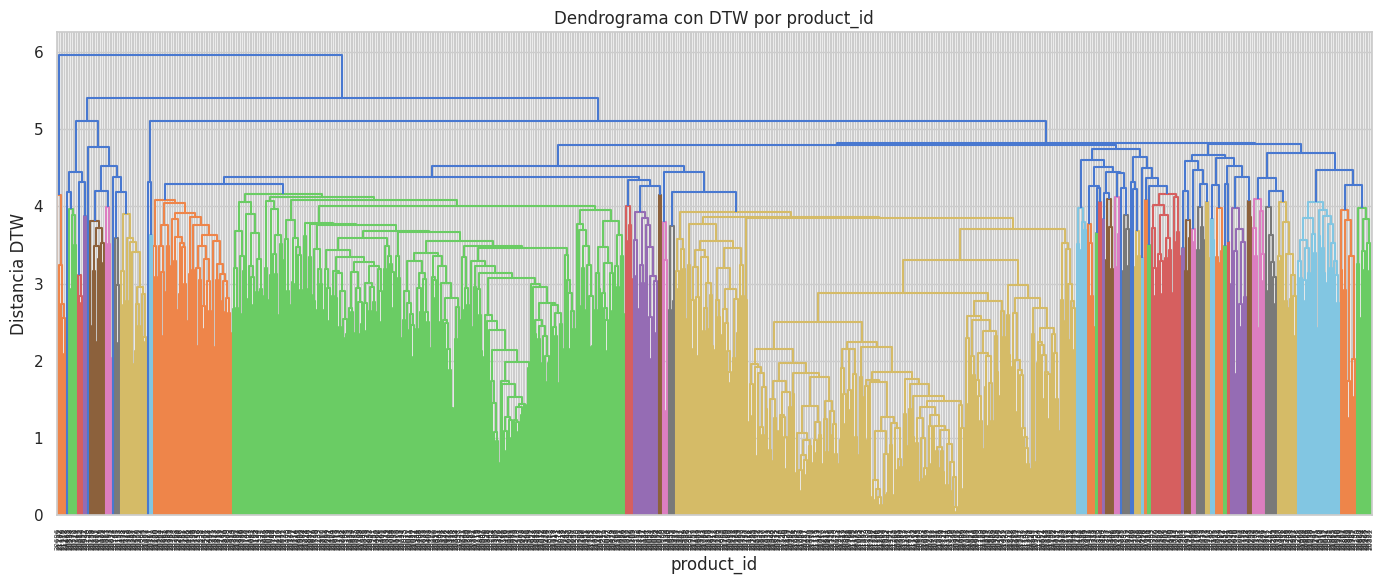

In [198]:
# Clustering jerárquico (average linkage recomendado con DTW)
Z = linkage(condensed_dtw, method='average')

# Dibujar dendrograma
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=pivot.index.astype(str).tolist())
plt.title("Dendrograma con DTW por product_id")
plt.xlabel("product_id")
plt.ylabel("Distancia DTW")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [226]:
# Cortar el dendrograma a una distancia específica
distancia_umbral = 4.18 # ajustá según el gráfico
labels = fcluster(Z, t=distancia_umbral, criterion='distance')
print("Etiquetas por distancia de corte:", labels)


Etiquetas por distancia de corte: [ 7  6 15 46 46 15 15 15  6 15 15 15 40 51 51 51 15 15 15 15 15 15 46 15
 51 46 13 18 15 15 51 21 15 15 15 15 15 15 43 15 17 51 15 17 48 51 15 15
 36 17 15 15 16 15 17 17 15 43 28 15 16 15 41 15 41 15 10 15 17 18 15 15
 17 15 15  6 21 15 15 21 15 39 15 15 17 47 15 15 15 19 15 21 15 15 12 14
 15 41 21 15  6 15 15 46 14  6 15 15 15 15 21 21 14 21 15 15 15 21 15 15
 40 15 15 21 15  8 15  6 21 15 46  8  8  8  6 21 32 45  9 21 16 40 15 21
 21 48 15 17 40 22 14 14 15 17 14 50 43 42 17 39 15 30 30 48 48 21 16 15
 14 30 22 21 15 43 21 49 15 21 15 15 15 47 51 15  6 15 51 15  6  6 15  9
 21 21 17 27 42 30 15 24 48 15 17 49 26 44 15 14 21 15 21 36 36 14 15 21
 36 14 49 46 15 14 14 29 36 22 15 53 28 26 50 14 15 21 14 15 11 51 14 51
 36  9 39 47 36 15 15 37 15 15  9 36 17 16 12  7 48 23  9 14 15 35  9 14
 21 53 15 36 48 46 17 15 28 19 14 14 21 14 19 15 26 20 15 50 15 23 15 15
  9 14 35 21 27 50 50 23 21 15 21 15 15 15 15 15 15 26 21 15 50  9 15 49
 15 15 36 15 14 2

In [227]:
# Contar cuantos valores únicos hay en labels
n_clusters = len(np.unique(labels))
print(f"Número de clusters encontrados: {n_clusters}")

# Contar cuantos valores únicos hay en cada cluster
unique_counts = pd.Series(labels).value_counts().sort_index()
print("Cantidad de product_id por cluster:")
print(unique_counts)

Número de clusters encontrados: 53
Cantidad de product_id por cluster:
1       6
2       5
3       1
4       4
5       2
6      10
7       4
8       4
9      16
10      1
11      1
12      2
13      1
14     47
15    233
16      5
17     15
18      2
19      4
20      4
21    238
22      6
23      5
24      2
25      2
26      7
27      4
28      5
29      1
30      4
31      1
32      1
33      2
34      2
35      2
36     18
37      2
38      4
39      3
40      5
41      3
42      3
43      5
44      2
45      2
46     10
47      3
48      8
49      7
50     12
51     25
52     10
53      9
Name: count, dtype: int64


In [228]:
# En el dataframe df_datos_norm, si existe la columna 'cluster', eliminarla
if 'cluster' in df_datos_norm.columns:
    df_datos_norm.drop(columns=['cluster'], inplace=True)

# Crear un DataFrame que asocie cada product_id con su etiqueta de cluster
df_clusters = pd.DataFrame({
    'product_id': pivot.index,  # el orden de pivot.index coincide con labels
    'cluster': labels
})

# Hacer merge con df_datos para asignar la etiqueta a cada fila
df_datos_norm = df_datos_norm.merge(df_clusters, on='product_id', how='left')


In [229]:
df_datos_norm

,product_id,periodo,tn,tn_1,tn_2,tn_3,tn_4,tn_5,tn_6,tn_7,tn_8,tn_9,tn_10,tn_11,clase,cluster
0,20001,2017-01-01,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.323111,7
1,20001,2017-02-01,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.117043,7
2,20001,2017-03-01,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353285,7
3,20001,2017-04-01,-1.117043,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414052,7
4,20001,2017-05-01,0.353285,-1.117043,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.250684,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,21276,2019-08-01,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,NaN,NaN,-0.595870,21
22345,21276,2019-09-01,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,NaN,-0.290890,21
22346,21276,2019-10-01,-0.595870,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,-0.882724,21
22347,21276,2019-11-01,-0.290890,-0.595870,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,21


## Crear un modelo de Regresión lineal para cada cluster

In [230]:
# Definir el rango de fechas para train
start_date = pd.to_datetime("2018-01-01")
end_date = pd.to_datetime("2019-02-01")

# definir el rango de fechas para predecir
start_date_p = pd.to_datetime("2019-01-01")
end_date_p = pd.to_datetime("2019-12-01")

periodos_modelo = 12

# Obtener los clusters únicos
clusters = df_datos_norm['cluster'].unique()

print(f"Cantidad de clusters encontrados: {len(clusters)}")


Cantidad de clusters encontrados: 53


In [231]:
# Calcular lags y clase
for i in range(1, periodos_modelo):
    df_datos_norm[f'tn_{i}'] = df_datos_norm.groupby('product_id')['tn'].shift(i)

df_datos_norm['clase'] = df_datos_norm.groupby('product_id')['tn'].shift(-2)

In [232]:
df_datos_norm

,product_id,periodo,tn,tn_1,tn_2,tn_3,tn_4,tn_5,tn_6,tn_7,tn_8,tn_9,tn_10,tn_11,clase,cluster
0,20001,2017-01-01,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.323111,7
1,20001,2017-02-01,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.117043,7
2,20001,2017-03-01,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353285,7
3,20001,2017-04-01,-1.117043,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414052,7
4,20001,2017-05-01,0.353285,-1.117043,-0.323111,-2.042103,-1.576908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.250684,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,21276,2019-08-01,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,NaN,NaN,-0.595870,21
22345,21276,2019-09-01,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,NaN,-0.290890,21
22346,21276,2019-10-01,-0.595870,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,-0.882724,21
22347,21276,2019-11-01,-0.290890,-0.595870,-0.649760,-0.792584,-1.044397,-0.110851,1.145074,1.360154,1.861848,NaN,NaN,NaN,NaN,21


## Entrenar el Modelo para cada cluster y predecir para 2019-12

In [333]:
# Paso 4: Definir mágicos y armar dataset de entrenamiento
magicos = [20001, 20002, 20010, 20004, 20005, 20006, 20007, 20021,
           20008, 20014, 20015, 20089, 20012, 20017, 20018, 20023, 20028,
           20100, 20085, 20126, 20003, 20022, 20045, 20027, 20127, 20061,
           20130, 20203, 20047, 20050, 20236, 20029, 20037, 20039, 20041,
           20077, 20072, 20055, 20030, 20043, 20033, 20038, 20052, 20080,
           20056, 20016, 20026, 20054, 20044, 20075, 20084, 20031, 20094,
           20148, 20095, 20013, 20049, 20116, 20143, 20184, 20024, 20065,
           20177, 20079, 20121, 20011, 20070, 20145, 20157, 20251, 20009,
           20025, 20174, 20112, 20261, 20020, 20073, 20160, 20166, 20155]

In [349]:
random.seed(666667)

# crear un dataframe df_salida vacio
df_salida = pd.DataFrame()
factor_correccion = 1.15
undersampling_factor = 1

# Ordenar los clusters
clusters = sorted(clusters)

for clus in clusters:
  # Entrenar el modelo
  campos = ['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)] + ['clase']
  train_df = df_datos_norm[(df_datos_norm['periodo'] == '2018-10') & (df_datos_norm['cluster'] == clus)]
  train_df = train_df.dropna(subset=campos)

  train_df = train_df[~train_df['product_id'].isin(magicos)]

  if len(train_df) > 0:
    # Hacer undersampling de los datos de entrenamiento
    unique_product_ids = train_df['product_id'].unique()
    num_product_ids_to_sample = int(len(unique_product_ids) * undersampling_factor)
    sampled_product_ids = random.sample(list(unique_product_ids), num_product_ids_to_sample)

    if len(sampled_product_ids) != 0:
      # Filtrar el DataFrame para incluir solo los product_id seleccionados al azar
      train_df = train_df[train_df['product_id'].isin(sampled_product_ids)].copy()

    x_train = train_df[['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)]]
    y_train = train_df['clase']

    modelo = LinearRegression()
    modelo.fit(x_train, y_train)

    # Imprimir los coeficientes y el intercepto del modelo
    print('\n--------------------------------------------------------------------')
    print(f"Cluster {clus}:")
    print("Coeficientes:", modelo.coef_)
    print("Intercepto  :", modelo.intercept_)
    print("R^2         :", modelo.score(x_train, y_train))
    print('--------------------------------------------------------------------')

    # Predecir el valor final
    df_test = df_datos_norm[(df_datos_norm['periodo'] == '2019-10') & (df_datos_norm['cluster'] == clus)].copy()

    campos_tn = ['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)]
    completos = df_test.dropna(subset=campos_tn).copy()
    completos = completos[~completos['product_id'].isin(magicos)]
    incompletos = df_test[~df_test.index.isin(completos.index)].copy()

    x_completos = completos[campos_tn]
    completos['pred_clase'] = modelo.predict(x_completos)

    incompletos['pred_clase'] = incompletos[campos_tn].mean(axis=1, skipna=True) * factor_correccion

    resultado_final = pd.concat([completos, incompletos]).sort_index()

    # concatenar al dataframe df_salida los valores de resultado_final
    df_salida = pd.concat([df_salida, resultado_final[['product_id', 'clase', 'pred_clase']]], ignore_index=True)

    # Eliminar dataset de resultado final
    del resultado_final


--------------------------------------------------------------------
Cluster 1:
Coeficientes: [-0.01546304  0.03813519  0.01398318 -0.01347685 -0.25660729 -0.18523717
 -0.22326248  0.09007219  0.055848   -0.25638481 -0.01805793  0.12471372]
Intercepto  : -0.689958591164183
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 2:
Coeficientes: [ 0.04583226 -0.0301592  -0.07455884 -0.01981892 -0.08749003  0.07836357
 -0.04428245 -0.02539781 -0.01820972  0.03880351 -0.03693136  0.0254679 ]
Intercepto  : -0.985739397272248
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 3:
Coeficientes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercepto  : -0.9905200355863729
R^2         : nan
--------------------------------------------------------------------

---------------------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 7:
Coeficientes: [ 0.11084218  0.01679578  0.10755801 -0.06394358  0.2124164  -0.00827147
 -0.11066512 -0.0269825  -0.1510308  -0.00953627  0.03950729 -0.10881474]
Intercepto  : -0.7224367574730505
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 8:
Coeficientes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercepto  : -1.766016666875156
R^2         : nan
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 9:
Coeficientes: [-0.2398702  -0.11043794 -1.12013707  2.30259409 -0.05164714 -1.45089284
 -0.28087681  0.34790026  0.719288    1.69109846 -0.17412865 -0.55215166]
Intercepto  : 0.15153498358622086
R^2         : 1.0
--------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 11:
Coeficientes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercepto  : -0.8489759499644396
R^2         : nan
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 12:
Coeficientes: [ 0.00069657  0.01169703  0.00026054 -0.00105439  0.00194072  0.00443425
  0.01148336 -0.00330886 -0.01323562  0.02167327 -0.02051994 -0.00947297]
Intercepto  : 0.3846167443460519
R^2         : 1.0
--------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 14:
Coeficientes: [ 0.11231139  0.22982981 -0.0719725  -0.22518095 -0.03093373 -0.15364467
  0.01465624 -0.06251416 -0.00305989  0.06228012  0.02067236 -0.05751666]
Intercepto  : -0.525176509743331
R^2         : 0.33819354987867856
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 15:
Coeficientes: [ 0.21831851  0.04686101 -0.1211691  -0.01982913 -0.01399353 -0.03774304
 -0.01390167  0.00106211 -0.00911497  0.03665258  0.00576435 -0.00393369]
Intercepto  : -0.6845047332112755
R^2         : 0.12035019647383138
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 16:
Coeficientes: [-0.09428485  0.21793124 -0.33425286  0.14311903  0.35743152 -0.19241906
 -0.15428129 -0.25783189  0.04586749 -0.20425696  0.20333929 -0.05058581

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 20:
Coeficientes: [ 0.13938767 -0.08965491 -0.09145284 -0.15918173 -0.11947595  0.31131985
  0.2035977   0.05737454  0.04420604  0.19769551  0.09998692 -0.04143457]
Intercepto  : -1.0208619523469782
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 21:
Coeficientes: [ 0.32249106  0.04622101 -0.07840596  0.10302207 -0.04576189  0.08464525
  0.08880328 -0.09596841 -0.03403472  0.00213951 -0.11189509  0.02083659]
Intercepto  : -0.32418396864543303
R^2         : 0.16667528615894478
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 22:
Coeficientes: [ 0.39443137  0.60414797  0.16014355 -0.05188825  0.21982975 -0.15490437

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


R^2         : nan
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 33:
Coeficientes: [-0.03530104  0.09271429 -0.09253459 -0.02952711  0.11184361  0.01496555
  0.00835269 -0.13194532 -0.01382632 -0.0477037   0.08110821  0.0663624 ]
Intercepto  : -0.26275002355454063
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 34:
Coeficientes: [-0.0764066   0.13252727 -0.07525835 -0.00567236 -0.01807388 -0.04780131
 -0.08992918  0.03729612  0.03490784  0.25105332 -0.14613407 -0.18427722]
Intercepto  : -0.47027886779358086
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 35:
Coeficientes: [-0.01281077  0.01506457 -0.0133129   0.01713136 -0.00323115  0.00293903
 -0.00310129  

In [351]:
df_salida


,product_id,clase,pred_clase
0,20696,0.863255,-0.356187
1,21170,-1.250533,-0.590062
2,21192,-0.625021,-0.432057
3,21202,-0.907667,-0.801816
4,21218,-0.668672,-0.444331
...,...,...,...
772,20820,-0.270085,-1.030061
773,20864,-0.808564,-0.910228
774,20892,-0.840666,-0.942058
775,20965,-1.024908,-1.058414


In [352]:
# Convertitr en en dataframe df_salida el valor de tn a la escala original
tn_scaler_path = SCALERS_DIR+'scalers.pkl'

scalers = {}
with open(tn_scaler_path, 'rb') as f:
    scalers = pickle.load(f)

scaled_tn = []
for product_id, group in df_salida.groupby('product_id'):
    group = group.copy()
    if product_id in scalers:
        scaler = scalers[product_id]
        group['clase_unscaled'] = scaler.inverse_transform(group[['clase']])
        group['pred_clase_unscaled'] = scaler.inverse_transform(group[['pred_clase']])
    else:
        print(f"Warning: No scaler found for product {product_id}")
        group['clase_unscaled'] = 0
        group['pred_clase_unscaled'] = 0
    scaled_tn.append(group)

df_salida = pd.concat(scaled_tn, axis=0)

In [353]:
# Calcular la metrica de la predicción para 2019-12
df_salida['Error_abs'] = abs(df_salida['pred_clase_unscaled'] - df_salida['clase_unscaled'])
df_salida['TFE'] = abs(df_salida['pred_clase_unscaled'] - df_salida['clase_unscaled']) / df_salida['clase_unscaled']

# Calcular error total absoluto
TFE = sum(df_salida['Error_abs']) / sum(df_salida['clase_unscaled'])
print(f"Error Total Absoluto: {TFE}")

Error Total Absoluto: 0.2887374158435927


In [354]:
df_salida

,product_id,clase,pred_clase,clase_unscaled,pred_clase_unscaled,Error_abs,TFE
28,20001,0.361745,0.350213,1504.68856,1501.298236,3.390324,0.002253
18,20002,0.260161,0.722370,1087.30855,1225.779671,138.471121,0.127352
102,20003,0.012145,-0.370212,892.50129,782.400889,110.100401,0.123362
693,20004,-0.152344,-0.219428,637.90002,623.053636,14.846384,0.023274
694,20005,-0.236762,-0.030913,593.24443,637.547442,44.303012,0.074679
...,...,...,...,...,...,...,...
598,21263,-0.516487,-0.489120,0.01270,0.016755,0.004055,0.319318
599,21265,-0.382399,0.087755,0.05007,0.098599,0.048529,0.969223
600,21266,-0.432199,0.101493,0.05121,0.104862,0.053652,1.047688
601,21267,-1.017256,0.245395,0.01569,0.111445,0.095755,6.102924


/tmp/ipython-input-355-1018974796.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')
/tmp/ipython-input-355-1018974796.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')


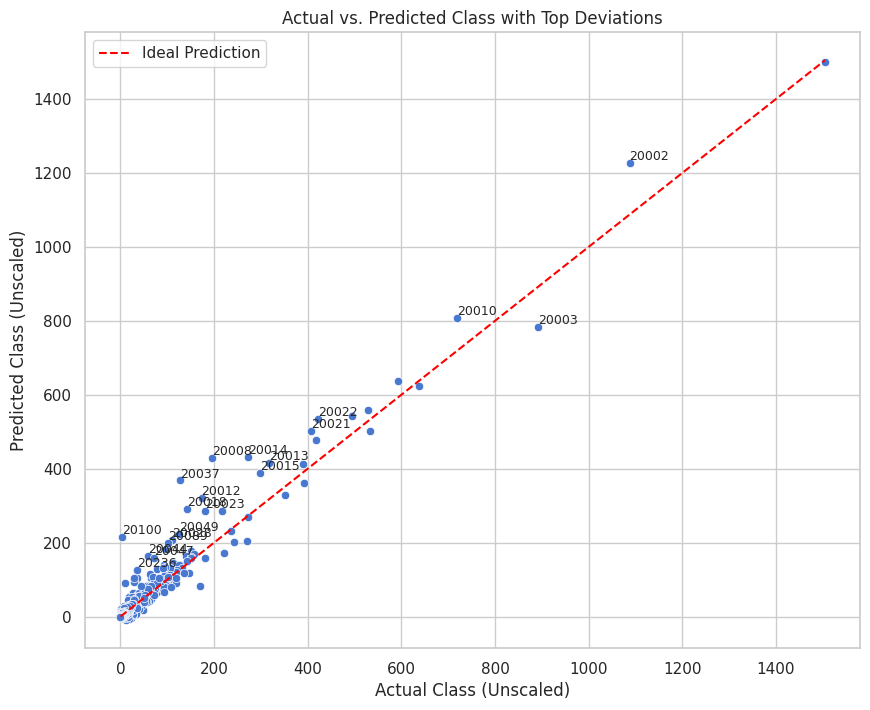

In [355]:
# Crear un gráfico para los datos del dataframe df_salida en donde en el eje x se grafique los valores del campo clase_unscaled, y en el eje y se grafique los valores del campo pred_clase_unscaled. Agregar al gráfico una línea recta a 45 grados con forma de línea de puntos y color rojo. Agregar en el gráfico etiquetas con el valor del campo product_id arriba de los puntos que tengan mayor distancia a la recta a 45 grados

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_salida, x='clase_unscaled', y='pred_clase_unscaled')

# Agregar la línea recta a 45 grados
max_val = max(df_salida['clase_unscaled'].max(), df_salida['pred_clase_unscaled'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')

# Calcular la distancia de cada punto a la recta a 45 grados
df_salida['distance_to_line'] = abs(df_salida['pred_clase_unscaled'] - df_salida['clase_unscaled']) / np.sqrt(2)

# Seleccionar los puntos con mayor distancia (por ejemplo, los 5 con mayor distancia)
top_n = 20
top_points = df_salida.nlargest(top_n, 'distance_to_line')

# Agregar etiquetas a los puntos seleccionados
for i, row in top_points.iterrows():
   plt.text(row['clase_unscaled'], row['pred_clase_unscaled'], str(int(row['product_id'])), fontsize=9, ha='left', va='bottom')

# Configurar las etiquetas y título del gráfico
plt.xlabel('Actual Class (Unscaled)')
plt.ylabel('Predicted Class (Unscaled)')
plt.title('Actual vs. Predicted Class with Top Deviations')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-334-591588552.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')
/tmp/ipython-input-334-591588552.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')
/tmp/ipython-input-334-591588552.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grafico['distance_to_line'] = abs(df_grafico['pred_clase_u

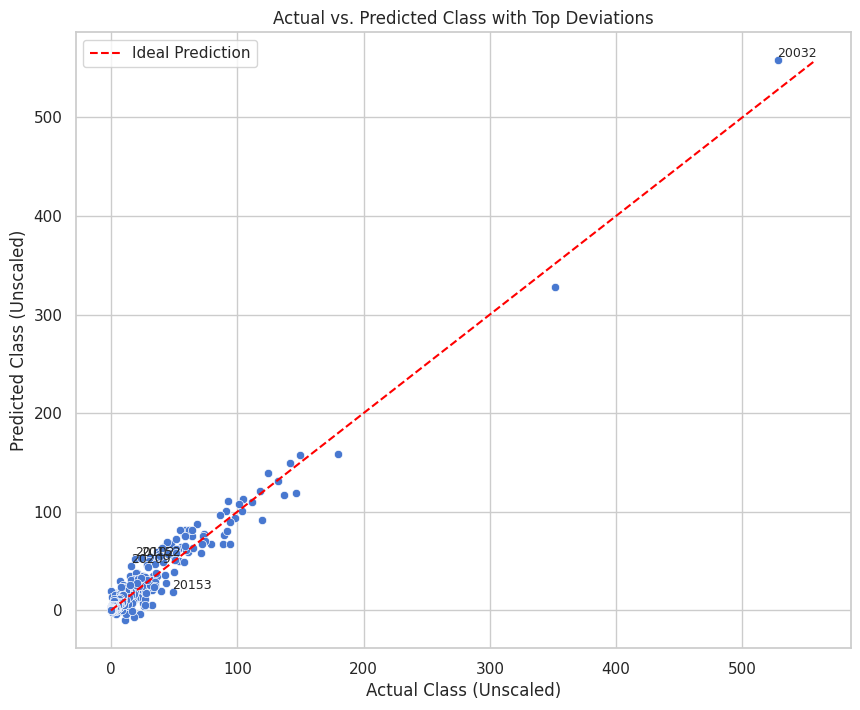

In [334]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))
df_grafico = df_salida[~df_salida['product_id'].isin(magicos)]

sns.scatterplot(data=df_grafico, x='clase_unscaled', y='pred_clase_unscaled')

# Agregar la línea recta a 45 grados
max_val = max(df_grafico['clase_unscaled'].max(), df_grafico['pred_clase_unscaled'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linestyle='--', color='red', label='Ideal Prediction')

# Calcular la distancia de cada punto a la recta a 45 grados
df_grafico['distance_to_line'] = abs(df_grafico['pred_clase_unscaled'] - df_grafico['clase_unscaled']) / np.sqrt(2)

# Seleccionar los puntos con mayor distancia (por ejemplo, los 5 con mayor distancia)
top_n =5
top_points = df_grafico.nlargest(top_n, 'distance_to_line')

# Agregar etiquetas a los puntos seleccionados
for i, row in top_points.iterrows():
   plt.text(row['clase_unscaled'], row['pred_clase_unscaled'], str(int(row['product_id'])), fontsize=9, ha='left', va='bottom')

# Configurar las etiquetas y título del gráfico
plt.xlabel('Actual Class (Unscaled)')
plt.ylabel('Predicted Class (Unscaled)')
plt.title('Actual vs. Predicted Class with Top Deviations')
plt.legend()
plt.grid(True)
plt.show()


In [335]:
# Calcular error total absoluto
TFE = sum(df_grafico['Error_abs']) / sum(df_grafico['clase_unscaled'])
print(f"Error Total Absoluto: {TFE}")

Error Total Absoluto: 0.3014880420497855


In [356]:
# Seleccionar de df_grafico los registros donde el TFE sea mayor a 0.15
df_grafico[df_grafico['TFE'] > 0.20]

,product_id,clase,pred_clase,clase_unscaled,pred_clase_unscaled,Error_abs,TFE,distance_to_line
132,20066,-0.282650,-1.026777,119.28134,91.839648,27.441692,0.230059,19.404207
336,20067,-1.034890,-1.498941,88.49566,67.784599,20.711061,0.234035,14.644931
356,20076,-1.547321,-0.687440,68.45922,88.040290,19.581070,0.286025,13.845907
141,20086,-1.528164,-0.726868,42.51979,65.004395,22.484605,0.528803,15.899017
143,20090,-1.274448,-0.872057,35.97712,53.361522,17.384402,0.483207,12.292629
...,...,...,...,...,...,...,...,...
598,21263,-0.516487,-0.489120,0.01270,0.016755,0.004055,0.319318,0.002868
599,21265,-0.382399,0.087755,0.05007,0.098599,0.048529,0.969223,0.034315
600,21266,-0.432199,0.101493,0.05121,0.104862,0.053652,1.047688,0.037938
601,21267,-1.017256,0.245395,0.01569,0.111445,0.095755,6.102924,0.067709


In [360]:
# prompt: crear un dataset df_salida_diciembre que contenga los datos de df_salida (solo las columnas product_id, y pred_clase), y agregue los product_id que faltan del dataset df_datos y en el campo pred_clase calcule el promedio del año 2019

# Seleccionar solo las columnas product_id y pred_clase de df_salida
df_salida_diciembre = df_salida[['product_id', 'pred_clase_unscaled']].copy()

# Renombrar la columna pred_clase_unscaled a pred_clase para consistencia con la descripción
df_salida_diciembre.rename(columns={'pred_clase_unscaled': 'tn'}, inplace=True)

# Obtener la lista de product_id presentes en df_salida_diciembre
productos_en_salida = df_salida_diciembre['product_id'].unique()

# Obtener la lista de product_id presentes en df_datos
productos_en_datos = df_datos['product_id'].unique()

# Encontrar los product_id que están en df_datos pero no en df_salida_diciembre
productos_faltantes = set(productos_en_datos) - set(productos_en_salida)

# Para los product_id faltantes, calcular el promedio de 'tn' para el año 2019
# Filtrar df_datos para el año 2019 y los productos faltantes
df_datos_2019_faltantes = df_datos[
    (df_datos['periodo'].dt.year == 2019) &
    (df_datos['product_id'].isin(productos_faltantes))
].copy()

# Calcular el promedio de 'tn' para cada product_id faltante en 2019
# Antes de agrupar, asegurarse de que 'tn' no sea None/NaN para el cálculo del promedio
#df_datos_2019_faltantes['tn'] = df_datos_2019_faltantes['tn'].fillna(0) # O usa otro método de imputación si es necesario

promedio_2019_faltantes = df_datos_2019_faltantes.groupby('product_id')['tn'].mean().reset_index()

# Crear un DataFrame para los productos faltantes con su promedio de 'tn'
#df_faltantes_diciembre = promedio_2019_faltantes.rename(columns={'tn': 'pred_clase'})

# Concatenar el dataframe de salida original con el dataframe de productos faltantes
df_salida_diciembre = pd.concat([df_salida_diciembre, promedio_2019_faltantes], ignore_index=True)

# Asegurar que todos los product_id de df_datos_products_to_predict estén en el resultado final
productos_target = df_products_to_predict['product_id'].unique()
productos_en_resultado = df_salida_diciembre['product_id'].unique()

productos_realmente_faltantes = set(productos_target) - set(productos_en_resultado)

# Para cualquier product_id que aún falte (que estaba en products_to_predict pero no en df_datos 2019 ni en df_salida)
# podrías asignarle un valor por defecto o un promedio global, o NaN.
# Aquí asignaremos 0 o un valor que represente que no hubo datos.
if productos_realmente_faltantes:
    print(f"Warning: Los siguientes product_id estaban en la lista a predecir pero no se encontraron datos para 2019: {productos_realmente_faltantes}")
    df_faltantes_completos = pd.DataFrame({'product_id': list(productos_realmente_faltantes), 'pred_clase': 0}) # Asignar 0
    df_salida_diciembre = pd.concat([df_salida_diciembre, df_faltantes_completos], ignore_index=True)


# Opcional: Ordenar por product_id
df_salida_diciembre = df_salida_diciembre.sort_values('product_id').reset_index(drop=True)

# Mostrar el resultado
print(df_salida_diciembre.head())
print(f"Cantidad de productos en df_salida_diciembre: {df_salida_diciembre['product_id'].nunique()}")
print(f"Cantidad de productos a predecir: {df_products_to_predict['product_id'].nunique()}")
print(f"¿Todos los productos a predecir están en df_salida_diciembre? {set(df_products_to_predict['product_id'].unique()).issubset(set(df_salida_diciembre['product_id'].unique()))}")

   product_id           tn
0       20001  1501.298236
1       20002  1225.779671
2       20003   782.400889
3       20004   623.053636
4       20005   637.547442
Cantidad de productos en df_salida_diciembre: 780
Cantidad de productos a predecir: 780
¿Todos los productos a predecir están en df_salida_diciembre? True


In [367]:
df_salida_diciembre[df_salida_diciembre['tn'] < 0]

,product_id,tn


In [366]:
# prompt: En el dataframe df_salida_diciembre reemplazar los valores del campo tn en negativo por el promedio de df_datos para el año  2019

# Calcular el promedio de 'tn' para el año 2019 en df_datos
# Asegurarse de filtrar por año 2019 y manejar posibles NaNs antes de calcular el promedio
df_datos_2019 = df_datos[df_datos['periodo'].dt.year == 2019].copy()
# Reemplazar NaNs en 'tn' con 0 antes de calcular el promedio para evitar que el promedio sea NaN
df_datos_2019['tn'] = df_datos_2019['tn'].fillna(0)
promedio_tn_2019_global = df_datos_2019['tn'].mean()

# Reemplazar los valores negativos en la columna 'tn' de df_salida_diciembre
# Seleccionar las filas donde 'tn' es negativo
negative_tn_mask = df_salida_diciembre['tn'] < 0

# Reemplazar los valores negativos con el promedio calculado
df_salida_diciembre.loc[negative_tn_mask, 'tn'] = promedio_tn_2019_global

print("Valores negativos en 'tn' de df_salida_diciembre reemplazados por el promedio de 'tn' en df_datos para 2019.")
print(df_salida_diciembre.head())
print(f"Cantidad de valores negativos restantes en 'tn': {df_salida_diciembre[df_salida_diciembre['tn'] < 0].shape[0]}")

Valores negativos en 'tn' de df_salida_diciembre reemplazados por el promedio de 'tn' en df_datos para 2019.
   product_id           tn
0       20001  1501.298236
1       20002  1225.779671
2       20003   782.400889
3       20004   623.053636
4       20005   637.547442
Cantidad de valores negativos restantes en 'tn': 0


In [368]:
# Grabar el dataframe df_salida en un archivo CSV
df_salida_diciembre.to_csv(OUTPUTS_DIR+'DTW_RL_Exp30_Dic.csv', index=False)

## Entrenar el modelo final y predecir 2020-02

In [369]:
random.seed(666667)

# crear un dataframe df_salida vacio
df_salida = pd.DataFrame()
factor_correccion = 1.15
undersampling_factor = 1

# Ordenar los clusters
clusters = sorted(clusters)

for clus in clusters:
  # Entrenar el modelo
  campos = ['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)] + ['clase']
  train_df = df_datos_norm[(df_datos_norm['periodo'] == '2018-12') & (df_datos_norm['cluster'] == clus)]
  train_df = train_df.dropna(subset=campos)

  train_df = train_df[~train_df['product_id'].isin(magicos)]

  if len(train_df) > 0:
    # Hacer undersampling de los datos de entrenamiento
    unique_product_ids = train_df['product_id'].unique()
    num_product_ids_to_sample = int(len(unique_product_ids) * undersampling_factor)
    sampled_product_ids = random.sample(list(unique_product_ids), num_product_ids_to_sample)

    if len(sampled_product_ids) != 0:
      # Filtrar el DataFrame para incluir solo los product_id seleccionados al azar
      train_df = train_df[train_df['product_id'].isin(sampled_product_ids)].copy()

    x_train = train_df[['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)]]
    y_train = train_df['clase']

    modelo = LinearRegression()
    modelo.fit(x_train, y_train)

    # Imprimir los coeficientes y el intercepto del modelo
    print('\n--------------------------------------------------------------------')
    print(f"Cluster {clus}:")
    print("Coeficientes:", modelo.coef_)
    print("Intercepto  :", modelo.intercept_)
    print("R^2         :", modelo.score(x_train, y_train))
    print('--------------------------------------------------------------------')

    # Predecir el valor final
    df_test = df_datos_norm[(df_datos_norm['periodo'] == '2019-12') & (df_datos_norm['cluster'] == clus)].copy()

    campos_tn = ['tn'] + [f'tn_{i}' for i in range(1, periodos_modelo)]
    completos = df_test.dropna(subset=campos_tn).copy()
    completos = completos[~completos['product_id'].isin(magicos)]
    incompletos = df_test[~df_test.index.isin(completos.index)].copy()

    x_completos = completos[campos_tn]
    completos['pred_clase'] = modelo.predict(x_completos)

    incompletos['pred_clase'] = incompletos[campos_tn].mean(axis=1, skipna=True) * factor_correccion

    resultado_final = pd.concat([completos, incompletos]).sort_index()

    # concatenar al dataframe df_salida los valores de resultado_final
    df_salida = pd.concat([df_salida, resultado_final[['product_id', 'clase', 'pred_clase']]], ignore_index=True)

    # Eliminar dataset de resultado final
    del resultado_final


--------------------------------------------------------------------
Cluster 1:
Coeficientes: [ 0.15952866  0.07157927 -0.01447715  0.00134251  0.04372993 -0.00349519
 -0.16513636 -0.11679642 -0.09345151  0.16108687  0.04567136 -0.18321123]
Intercepto  : -0.43598291234829667
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 2:
Coeficientes: [ 0.07150241  0.07277579 -0.10185274 -0.06449798 -0.15318028 -0.25179554
 -0.06248303  0.19623221 -0.20526714 -0.41994422  0.18264013  0.09101246]
Intercepto  : 0.3201259423574497
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 3:
Coeficientes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Intercepto  : 0.01618788187390072
R^2         : nan
--------------------------------------------------------------------

-------------------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 15:
Coeficientes: [ 0.11188391 -0.03683805  0.15909311 -0.29849306  0.07344011 -0.02110146
  0.00042003 -0.0040767   0.06730119  0.04198806  0.10437401  0.07802844]
Intercepto  : -0.5122627753870359
R^2         : 0.14327521287473355
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 16:
Coeficientes: [-6.84337926e-02 -1.61957518e-01  1.26572940e-01 -7.67239827e-02
 -6.40486055e-03 -5.34696858e-02  9.62962746e-02  1.86055069e-01
 -2.50480496e-04  5.67149433e-02  2.67154495e-01  2.84498331e-02]
Intercepto  : -0.7761823496456837
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 17:
Coeficientes: [-0.11570957  0.08980916  0.16859223 -0.00218905 -0.05803822 -0.33740855
 -0.01530046 -0.14061956  0.35385065  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 26:
Coeficientes: [ 0.37576932  0.42590642 -0.16236293  0.22509439 -0.0303938  -0.31522389
  0.12063801  0.3309237   0.43105852  0.06590449 -0.46856119  0.10466542]
Intercepto  : -0.5029534142079183
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 27:
Coeficientes: [-0.10958526 -0.15053372  0.03649306  0.03997577  0.00970158  0.13549784
  0.02088452 -0.1834986   0.03953731  0.01719355  0.0127626   0.15629978]
Intercepto  : -0.6139180212331035
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 28:
Coeficientes: [-0.01273281 -0.00475483 -0.02781786  0.01778875 -0.02243934 -0.02638053
  0.01560564  0.00764469  0.02400536 -0.07073502  0.08331127 -0.09055283]
Intercepto  : -0.014116044636

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--------------------------------------------------------------------
Cluster 40:
Coeficientes: [-0.00672566  0.03331499  0.00520681  0.01943432 -0.03796982 -0.06157453
  0.09785822 -0.03027679  0.10258004  0.02189385 -0.01353402 -0.00441761]
Intercepto  : -0.17793906577829882
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 41:
Coeficientes: [-0.0730955   0.0928768   0.01934743  0.02731685  0.07717243  0.09750896
  0.02147178  0.0347236   0.03305987  0.03632104 -0.07878278  0.06783899]
Intercepto  : 0.18653595156903413
R^2         : 1.0
--------------------------------------------------------------------

--------------------------------------------------------------------
Cluster 42:
Coeficientes: [-0.12317193  0.01560528 -0.07484736  0.09693092 -0.15112787 -0.02343343
 -0.16326334  0.15381967  0.00414881  0.08835356 -0.04165053  0.02022876]
Intercepto  : 1.166353975937

In [370]:
df_salida

,product_id,clase,pred_clase
0,20696,NaN,-0.136733
1,21170,NaN,-0.682176
2,21192,NaN,-0.452969
3,21202,NaN,-0.740469
4,21218,NaN,-0.482495
...,...,...,...
772,20820,NaN,0.600495
773,20864,NaN,1.337541
774,20892,NaN,1.437345
775,20965,NaN,1.754438


In [371]:
# Convertitr en en dataframe df_salida el valor de tn a la escala original
tn_scaler_path = SCALERS_DIR+'scalers.pkl'

scalers = {}
with open(tn_scaler_path, 'rb') as f:
    scalers = pickle.load(f)

scaled_tn = []
for product_id, group in df_salida.groupby('product_id'):
    group = group.copy()
    if product_id in scalers:
        scaler = scalers[product_id]
        group['pred_clase_unscaled'] = scaler.inverse_transform(group[['pred_clase']])
    else:
        print(f"Warning: No scaler found for product {product_id}")
        group['pred_clase_unscaled'] = 0
    scaled_tn.append(group)

df_salida = pd.concat(scaled_tn, axis=0)

In [374]:
# Eliminar la columna clase y pred_clase en el dataframe df_salida
df_salida.drop(columns=['clase', 'pred_clase'], inplace=True)

# renombrar la columna pred_clase_unscales como tn en el dataframe df_salida
df_salida.rename(columns={'pred_clase_unscaled': 'tn'}, inplace=True)

In [375]:
df_salida

,product_id,tn
28,20001,1463.190980
18,20002,1200.347486
102,20003,769.372232
693,20004,620.555320
694,20005,671.880543
...,...,...
598,21263,0.098934
599,21265,0.089541
600,21266,0.094659
601,21267,0.092835


In [379]:
# En el dataframe df_salida, seleccionar los registros con valor tn < 0
df_salida[df_salida['tn'] < 0]

,product_id,tn


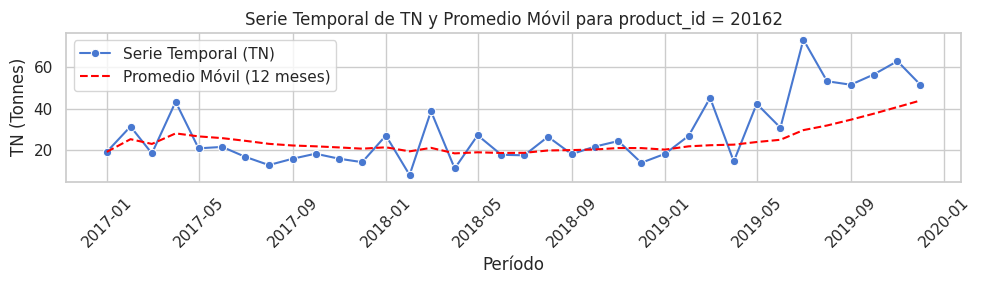

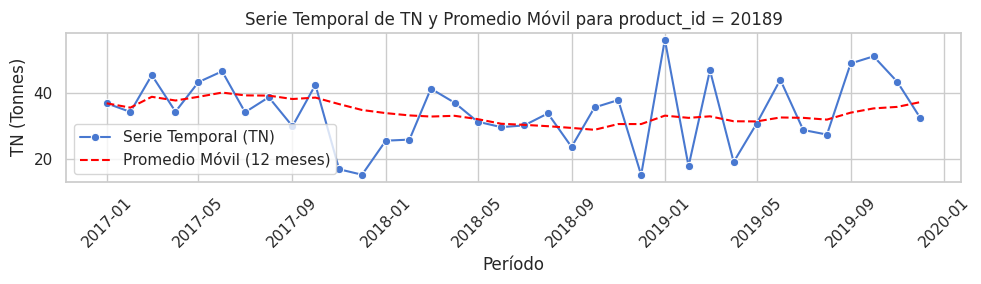

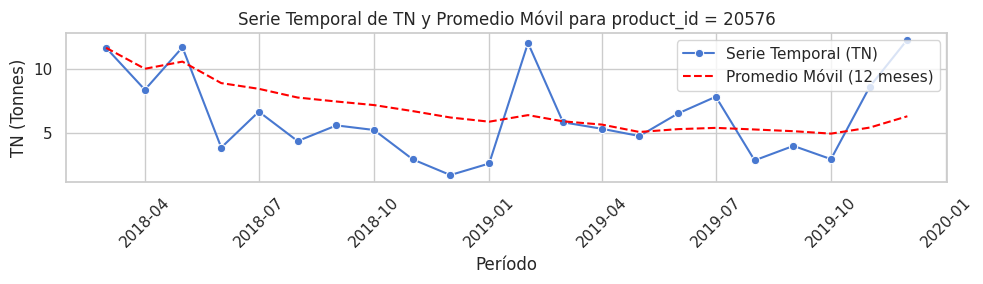

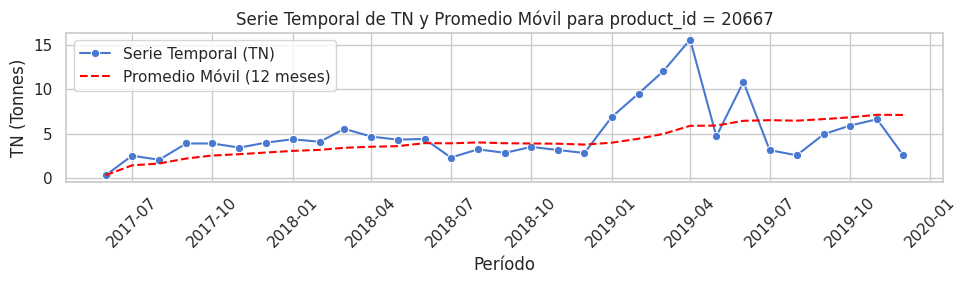

In [377]:
# prompt: En el dataframe df_datos, graficar la serie temporal para el product_id == 20005 y graficar también en una línea el promedio de los últimos 12 meses
products_a_graficar = [20162, 20189, 20576, 20667]
df_promedios_12_meses = pd.DataFrame()

import pandas as pd
import matplotlib.pyplot as plt

for producto in products_a_graficar:
    # Filtrar los datos para el product_id específico
    df_producto_especifico = df_datos[df_datos['product_id'] == producto].copy()

    # Asegurarse de que la columna 'periodo' sea de tipo datetime y esté ordenada
    df_producto_especifico['periodo'] = pd.to_datetime(df_producto_especifico['periodo'])
    df_producto_especifico = df_producto_especifico.sort_values(by='periodo')

    # Calcular el promedio móvil de los últimos 12 meses
    # Usar `rolling(window=12)` para la ventana de 12 meses y `mean()` para el promedio
    # `min_periods=1` permite calcular el promedio incluso si no hay 12 meses completos al principio
    df_producto_especifico['tn_rolling_avg_12'] = df_producto_especifico['tn'].rolling(window=12, min_periods=1).mean()

    # Graficar la serie temporal y el promedio móvil
    plt.figure(figsize=(10, 3))

    # Graficar la serie temporal original
    sns.lineplot(data=df_producto_especifico, x='periodo', y='tn', label='Serie Temporal (TN)', marker='o')

    # Graficar el promedio móvil de los últimos 12 meses
    sns.lineplot(data=df_producto_especifico, x='periodo', y='tn_rolling_avg_12', label='Promedio Móvil (12 meses)', color='red', linestyle='--')

    plt.title(f'Serie Temporal de TN y Promedio Móvil para product_id = ' + str(producto))
    plt.xlabel('Período')
    plt.ylabel('TN (Tonnes)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Concatenar en el dataframe df_promedios_12_meses el valor del dataframe df_producto_especifico para el perido 2019-12, solo las columnas product_id y tn_rolling_avg_12
    df_promedios_12_meses = pd.concat([df_promedios_12_meses, df_producto_especifico[['product_id', 'tn_rolling_avg_12']][df_producto_especifico['periodo'] == '2019-12']])


In [378]:
# prompt: en el dataframe df_salida reemplazar para el product_id que exista en el dataframe df_promedios_12_meses el valor de la columna tn por tn_rolling_avg_12

# Asegurarse de que las columnas 'product_id' sean del mismo tipo en ambos dataframes
df_promedios_12_meses['product_id'] = df_promedios_12_meses['product_id'].astype(df_salida['product_id'].dtype)

# Ahora, usar update. update modificará df_salida in-place.
# Alineamos por 'product_id' (el índice de df_promedios_indexed)
# y actualizamos la columna 'tn' en df_salida con los valores de 'tn_rolling_avg_12'.
df_salida = df_salida.merge(df_promedios_12_meses, on='product_id', how='left')

df_salida.loc[df_salida['tn_rolling_avg_12'].notnull(), 'tn'] = df_salida['tn_rolling_avg_12']

# Eliminar la columna tn_rolling_avg_12 en el dataframe df_salida
df_salida.drop(columns=['tn_rolling_avg_12'], inplace=True)
df_salida


,product_id,tn
0,20001,1463.190980
1,20002,1200.347486
2,20003,769.372232
3,20004,620.555320
4,20005,671.880543
...,...,...
772,21263,0.098934
773,21265,0.089541
774,21266,0.094659
775,21267,0.092835


In [380]:
# prompt: crear un dataset df_salida_diciembre que contenga los datos de df_salida (solo las columnas product_id, y pred_clase), y agregue los product_id que faltan del dataset df_datos y en el campo pred_clase calcule el promedio del año 2019

# Seleccionar solo las columnas product_id y pred_clase de df_salida
df_salida_final = df_salida[['product_id', 'tn']].copy()

# Obtener la lista de product_id presentes en df_salida_diciembre
productos_en_salida = df_salida_final['product_id'].unique()

# Obtener la lista de product_id presentes en df_datos
productos_en_datos = df_datos['product_id'].unique()

# Encontrar los product_id que están en df_datos pero no en df_salida_diciembre
productos_faltantes = set(productos_en_datos) - set(productos_en_salida)

# Para los product_id faltantes, calcular el promedio de 'tn' para el año 2019
# Filtrar df_datos para el año 2019 y los productos faltantes
df_datos_2019_faltantes = df_datos[
    (df_datos['periodo'].dt.year == 2019) &
    (df_datos['product_id'].isin(productos_faltantes))
].copy()

# Calcular el promedio de 'tn' para cada product_id faltante en 2019
# Antes de agrupar, asegurarse de que 'tn' no sea None/NaN para el cálculo del promedio
df_datos_2019_faltantes['tn'] = df_datos_2019_faltantes['tn'].fillna(0) # O usa otro método de imputación si es necesario
promedio_2019_faltantes = df_datos_2019_faltantes.groupby('product_id')['tn'].mean().reset_index()

# Concatenar el dataframe de salida original con el dataframe de productos faltantes
df_salida_final = pd.concat([df_salida_final, promedio_2019_faltantes], ignore_index=True)

# Asegurar que todos los product_id de df_datos_products_to_predict estén en el resultado final
productos_target = df_products_to_predict['product_id'].unique()
productos_en_resultado = df_salida_final['product_id'].unique()

productos_realmente_faltantes = set(productos_target) - set(productos_en_resultado)

# Para cualquier product_id que aún falte (que estaba en products_to_predict pero no en df_datos 2019 ni en df_salida)
# podrías asignarle un valor por defecto o un promedio global, o NaN.
# Aquí asignaremos 0 o un valor que represente que no hubo datos.
if productos_realmente_faltantes:
    print(f"Warning: Los siguientes product_id estaban en la lista a predecir pero no se encontraron datos para 2019: {productos_realmente_faltantes}")
    df_faltantes_completos = pd.DataFrame({'product_id': list(productos_realmente_faltantes), 'pred_clase': 0}) # Asignar 0
    df_salida_final = pd.concat([df_salida_final, df_faltantes_completos], ignore_index=True)

# Opcional: Ordenar por product_id
df_salida_final = df_salida_final.sort_values('product_id').reset_index(drop=True)

# Mostrar el resultado
print(df_salida_final.head())
print(f"Cantidad de productos en df_salida_final: {df_salida_final['product_id'].nunique()}")
print(f"Cantidad de productos a predecir: {df_products_to_predict['product_id'].nunique()}")
print(f"¿Todos los productos a predecir están en df_salida_final? {set(df_products_to_predict['product_id'].unique()).issubset(set(df_salida_final['product_id'].unique()))}")

   product_id           tn
0       20001  1463.190980
1       20002  1200.347486
2       20003   769.372232
3       20004   620.555320
4       20005   671.880543
Cantidad de productos en df_salida_final: 780
Cantidad de productos a predecir: 780
¿Todos los productos a predecir están en df_salida_final? True


In [381]:
# Grabar el dataframe df_salida en un archivo CSV
df_salida_final.to_csv(OUTPUTS_DIR+'DTW_RL_Exp30.csv', index=False)